


# 1.Load and Preprocess the Dataset




In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns

df = pd.read_csv('kmeans_dataset.csv')

# 1. Choose specific columns
columns_to_keep = ['Age', 'Annual_Income', 'Spending_Score', 'Total_Purchase_Amount']
df_selected = df[columns_to_keep]

# 2. Remove null values
df_cleaned = df_selected.dropna()
print(f"Rows after removing nulls: {df_cleaned.shape[0]}")

# 3. Remove duplicates
df_no_duplicates = df_cleaned.drop_duplicates()
print(f"Rows after removing duplicates: {df_no_duplicates.shape[0]}")

# 4. Normalize the numerical values (mean 0, std 1)
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df_no_duplicates)

print(df_normalized)

Rows after removing nulls: 396
Rows after removing duplicates: 396
[[ 0.55367799  4.09947753 -0.78643057  4.10951117]
 [-0.05368069  1.02129393 -1.5527188  -1.12049839]
 [ 0.79662146  0.75144741 -0.22913003  0.76001538]
 ...
 [-0.29662416  0.89357305 -0.5077803  -0.05582231]
 [ 1.70765947  0.28008657 -0.64710543 -0.19429794]
 [-0.47883177  0.23972662 -1.23923725 -0.62699901]]


# 2. Determine the Optimal Number of Clusters (K)

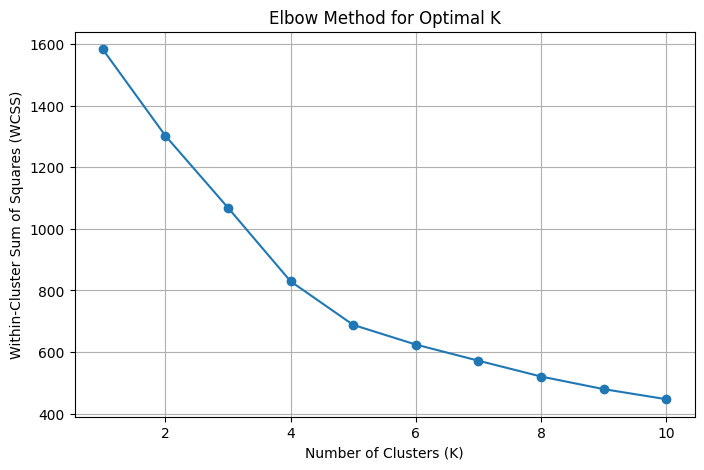

In [36]:
k_range = range(1, 11)  # Testing 1 to 10 clusters
wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_normalized)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

K=2, Silhouette Score=0.189
K=3, Silhouette Score=0.207
K=4, Silhouette Score=0.198
K=5, Silhouette Score=0.228
K=6, Silhouette Score=0.223
K=7, Silhouette Score=0.214
K=8, Silhouette Score=0.215
K=9, Silhouette Score=0.225
K=10, Silhouette Score=0.223


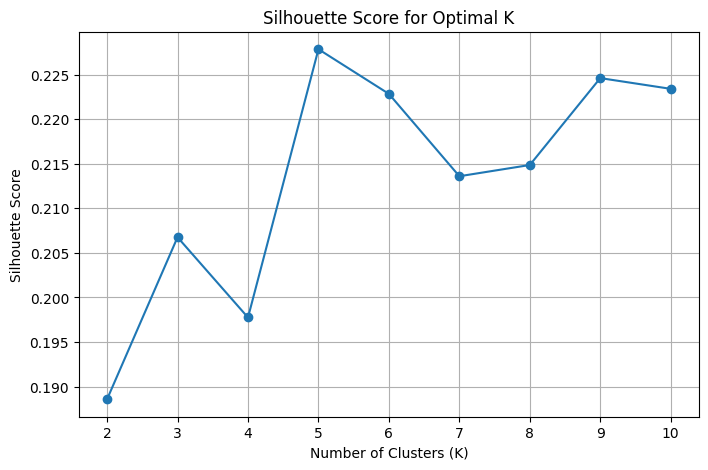

Optimal K based on Silhouette Score: 5


In [37]:
"""
The Silhouette Score measures how similar each point is to its own cluster compared to other clusters.
 It ranges from -1 (bad clustering) to 1 (good clustering).
 You calculate it for different K values and pick the K with the highest average score.
 """

 # Range of K values to test (since silhouette needs >1 cluster)
k_range = range(2, 11)
silhouette_scores = []

# Calculate Silhouette Score for each K
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_normalized)
    score = silhouette_score(df_normalized, cluster_labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score:.3f}")

# Plot the Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Find the optimal K
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal K based on Silhouette Score: {optimal_k}")


# 3.Apply K-Means Clustering

In [38]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(df_normalized)

# Add cluster labels to the original (non-normalized) DataFrame for interpretation
df_no_duplicates['Cluster'] = cluster_labels

# Check the first few rows with cluster assignments
print(df_no_duplicates.head())

    Age  Annual_Income  Spending_Score  Total_Purchase_Amount  Cluster
0  56.0       299578.0            26.0                99756.0        1
2  46.0       137813.0             4.0                 7110.0        2
4  60.0       123632.0            42.0                40422.0        0
6  38.0       124692.0            18.0                43413.0        4
7  56.0        97235.0            40.0                31997.0        2


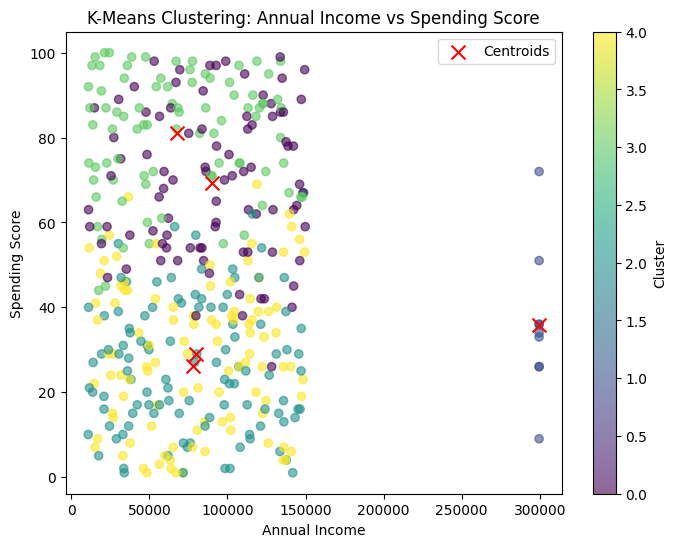

In [39]:
# Scatter plot of Annual_Income vs Spending_Score, colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_no_duplicates['Annual_Income'],
                      df_no_duplicates['Spending_Score'],
                      c=df_no_duplicates['Cluster'],
                      cmap='viridis',
                      alpha=0.6)

# Add cluster centroids (optional)
centroids = kmeans.cluster_centers_
# Reverse normalization to plot centroids in original scale
centroids_original = scaler.inverse_transform(centroids)
plt.scatter(centroids_original[:, 1],  # Annual_Income is index 1
            centroids_original[:, 2],  # Spending_Score is index 2
            c='red', marker='x', s=100, label='Centroids')
# Customize the plot
plt.title('K-Means Clustering: Annual Income vs Spending Score')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()



# 4.Cluster Interpretation


In [40]:
# Calculate and display average values per cluster
cluster_means = df_no_duplicates.groupby('Cluster').mean()
print("Average Values per Cluster:")
print(cluster_means)

# Display cluster sizes
cluster_sizes = df_no_duplicates['Cluster'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_sizes)

Average Values per Cluster:
               Age  Annual_Income  Spending_Score  Total_Purchase_Amount
Cluster                                                                 
0        54.325843   90329.033708       69.325843           37485.067416
1        43.333333  299578.000000       35.888889           99756.000000
2        61.642202   77999.633028       26.155963           22866.697248
3        40.400000   67918.847059       81.035294           13210.117647
4        30.653846   79900.288462       28.894231           27176.932692

Cluster Sizes:
Cluster
0     89
1      9
2    109
3     85
4    104
Name: count, dtype: int64


 # 5.Handling Outliers


In [41]:
def remove_outliers(df, columns):
    df_out = df.copy()
    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Keep only non-outliers
        df_out = df_out[(df_out[col] >= lower_bound) & (df_out[col] <= upper_bound)]
    return df_out

columns_to_keep = ['Age', 'Annual_Income', 'Spending_Score', 'Total_Purchase_Amount']

df_no_outliers = remove_outliers(df_no_duplicates, columns_to_keep)
print(f"Rows before outlier removal: {df_no_duplicates.shape[0]}")
print(f"Rows after outlier removal: {df_no_outliers.shape[0]}")

# Normalize the data without outliers
scaler_no_outliers = StandardScaler()
df_normalized_no_outliers = scaler_no_outliers.fit_transform(df_no_outliers[columns_to_keep])

Rows before outlier removal: 396
Rows after outlier removal: 387



Cluster Means (No Outliers):
                           Age  Annual_Income  Spending_Score  \
Cluster_No_Outliers                                             
0                    39.721519   57630.405063       81.582278   
1                    28.220588   82223.661765       35.411765   
2                    57.903614   40521.626506       32.192771   
3                    47.067568  109037.851351       30.567568   
4                    58.192771  109010.469880       61.771084   

                     Total_Purchase_Amount   Cluster  
Cluster_No_Outliers                                   
0                             14214.898734  2.924051  
1                             35701.720588  3.588235  
2                             28935.361446  1.891566  
3                             10896.364865  2.918919  
4                             36376.409639  0.493976  

Cluster Sizes:
Cluster_No_Outliers
0    79
1    68
2    83
3    74
4    83
Name: count, dtype: int64


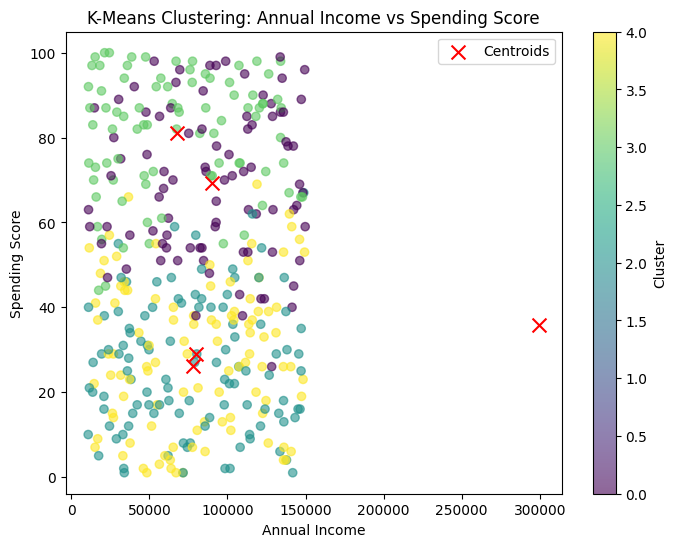

In [49]:
# K-means on data without outliers
kmeans_no_outliers = KMeans(n_clusters=optimal_k, random_state=42)
labels_no_outliers = kmeans_no_outliers.fit_predict(df_normalized_no_outliers)
df_no_outliers['Cluster_No_Outliers'] = labels_no_outliers

# Calculate cluster means for comparison
means_no_outliers = df_no_outliers.groupby('Cluster_No_Outliers').mean()

print("\nCluster Means (No Outliers):")
print(means_no_outliers.head())

# Display cluster sizes
cluster_sizes = df_no_outliers['Cluster_No_Outliers'].value_counts().sort_index()
print("\nCluster Sizes:")
print(cluster_sizes)

# Scatter plot of Annual_Income vs Spending_Score, colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df_no_outliers['Annual_Income'],
                      df_no_outliers['Spending_Score'],
                      c=df_no_outliers['Cluster'],
                      cmap='viridis',
                      alpha=0.6)

# Add cluster centroids (optional)
centroids = kmeans.cluster_centers_
# Reverse normalization to plot centroids in original scale
centroids_original = scaler.inverse_transform(centroids)
plt.scatter(centroids_original[:, 1],  # Annual_Income is index 1
            centroids_original[:, 2],  # Spending_Score is index 2
            c='red', marker='x', s=100, label='Centroids')
# Customize the plot
plt.title('K-Means Clustering: Annual Income vs Spending Score')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()

# # Pairplot to visualize clusters
# sns.pairplot(df_no_outliers, hue='Cluster_No_Outliers', diag_kind='kde', palette='viridis')
# plt.show()

# 6.Comparison with Other Clustering Algorithms


In [43]:
# Define parameter ranges
eps_values = [0.2, 0.3, 0.5, 0.7, 0.8, 1.0]
min_samples_values = [3, 4, 5, 6]

# Initialize variables to track the best result
best_score = -0.265  # Current best Silhouette Score
best_eps = None
best_min_samples = None
best_labels = None

# Test different combinations of eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_normalized)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        if n_clusters >= 2:
            score = silhouette_score(df_normalized, labels)
            print(f"eps={eps}, min_samples={min_samples}, Clusters={n_clusters}, Noise={n_noise}, Silhouette={score:.3f}")
            # Update best configuration if score improves
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels
                df_no_duplicates['DBSCAN_Cluster'] = labels
        else:
            print(f"eps={eps}, min_samples={min_samples}, Clusters={n_clusters}, Noise={n_noise}, Not enough clusters")

# Summary of the best result
print(f"\nBest Configuration: eps={best_eps}, min_samples={best_min_samples}, Best Silhouette Score={best_score:.3f}")

eps=0.2, min_samples=3, Clusters=0, Noise=396, Not enough clusters
eps=0.2, min_samples=4, Clusters=0, Noise=396, Not enough clusters
eps=0.2, min_samples=5, Clusters=0, Noise=396, Not enough clusters
eps=0.2, min_samples=6, Clusters=0, Noise=396, Not enough clusters
eps=0.3, min_samples=3, Clusters=2, Noise=390, Silhouette=0.059
eps=0.3, min_samples=4, Clusters=0, Noise=396, Not enough clusters
eps=0.3, min_samples=5, Clusters=0, Noise=396, Not enough clusters
eps=0.3, min_samples=6, Clusters=0, Noise=396, Not enough clusters
eps=0.5, min_samples=3, Clusters=34, Noise=222, Silhouette=-0.187
eps=0.5, min_samples=4, Clusters=15, Noise=305, Silhouette=-0.292
eps=0.5, min_samples=5, Clusters=5, Noise=355, Silhouette=-0.265
eps=0.5, min_samples=6, Clusters=3, Noise=371, Silhouette=-0.227
eps=0.7, min_samples=3, Clusters=8, Noise=28, Silhouette=-0.125
eps=0.7, min_samples=4, Clusters=8, Noise=48, Silhouette=-0.185
eps=0.7, min_samples=5, Clusters=10, Noise=83, Silhouette=-0.246
eps=0.7, min


DBSCAN Cluster Means:
                       Age  Annual_Income  Spending_Score  \
DBSCAN_Cluster                                             
-1              63.750000   299578.00000       43.750000   
 0              46.966408    79131.72093       48.873385   
 1              27.000000   299578.00000       29.600000   

                Total_Purchase_Amount   Cluster  
DBSCAN_Cluster                                   
-1                       99756.000000  1.000000  
 0                       25265.896641  2.297158  
 1                       99756.000000  1.000000  

DBSCAN Cluster Sizes:
 DBSCAN_Cluster
-1      4
 0    387
 1      5
Name: count, dtype: int64


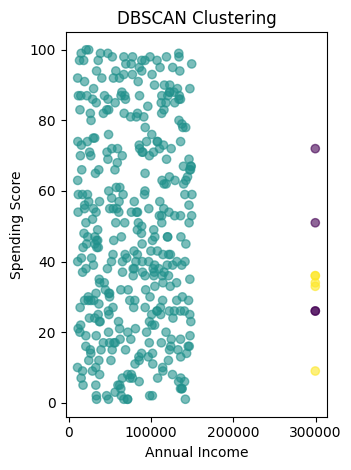

In [46]:
dbscan_means = df_no_duplicates.groupby('DBSCAN_Cluster').mean()
print("\nDBSCAN Cluster Means:\n", dbscan_means)

dbscan_sizes = df_no_duplicates['DBSCAN_Cluster'].value_counts().sort_index()
print("\nDBSCAN Cluster Sizes:\n", dbscan_sizes)

# DBSCAN
plt.subplot(1, 2, 2)
plt.scatter(df_no_duplicates['Annual_Income'],
            df_no_duplicates['Spending_Score'],
            c=df_no_duplicates['DBSCAN_Cluster'],
            cmap='viridis', alpha=0.6)
plt.title('DBSCAN Clustering')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.tight_layout()
plt.show()